In [1]:
import pandas as pd

df = pd.read_csv('../data/eval/test.csv', encoding='utf-8')

In [2]:
df.head()

,User input,Retrieved Contexts,Response,Reference (Reference answer),Type,Source
0,Đối tượng được dự thi tiếng Anh nội bộ,NaN,NaN,Đối tượng được dự thi tiếng Anh nội bộ là toàn...,paragraph,Quy định tiếng Anh nội bộ
1,Hội đồng chấm thi tiếng Anh nội bộ gồm những ai,NaN,NaN,Hội đồng thi gồm:\n- Giám đốc ra quyết định th...,bullet,NaN
2,Các tiểu ban tổ chức thi tiếng Anh nội bộ,NaN,NaN,Chủ tịch HĐT ra quyết định thành lập các tiểu ...,paragraph,NaN
3,Nhiệm vụ của các tiểu ban trong tổ chức tiếng ...,NaN,NaN,- Tiểu ban Đề thi có nhiệm vụ tư vấn và tổ chứ...,NaN,NaN
4,Vai trò trong công tác tổ chức thi của các bên,NaN,NaN,a) Tiểu ban Coi thi – Tổ chức thi phối hợp với...,NaN,NaN


In [12]:
import weaviate
from sqlalchemy import (
    MetaData,
)
from utils.utils import (
    get_llm,
    get_retriever,
    split_doc,
    get_embedding,
    get_vectorstore,
    get_retriever,
    get_websearch,
    get_table,
    get_sql_engine,
    get_database
)
from model import Pipeline

def build_comp():
    model = "llama3.1"
    text_dir = "../data/parse/text"

    # GET LLM
    llm = get_llm(model=model, format="")
    llm_json_mode = get_llm(model=model, format="json")

    # BUILD RETRIEVER
    doc_list = split_doc(text_dir)
    embedding = get_embedding(model_name="BAAI/BGE-M3")

    client = weaviate.connect_to_local()
    vectorstore = get_vectorstore(client=client, doc_list=doc_list, embedding_model=embedding, index_name="Hust_doc")
    retriever = get_retriever(vectorstore=vectorstore, k=3)
    
    web_search_tool = get_websearch()

    # Build SQL Database
    metadata_obj = MetaData()
    table = get_table(table_name="teacher", metadata_obj=metadata_obj)
    engine = get_sql_engine()
    db = get_database(engine=engine, metadata_obj=metadata_obj)
    return llm, llm_json_mode, retriever, db, web_search_tool

llm, llm_json_mode, retriever, db, web_search_tool = build_comp()

__GETTING MODEL__
__GETTING MODEL__
__SPLITTING__
__WEB SEARCH__


In [15]:
pipeline = Pipeline(llm, llm_json_mode, retriever, db, web_search_tool)

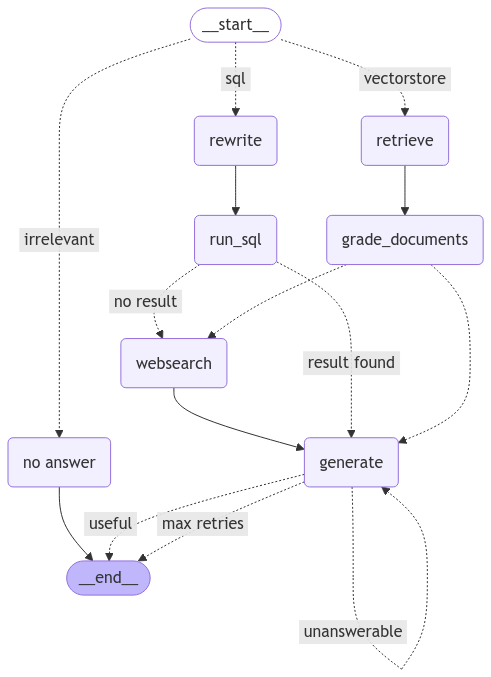

In [17]:
from IPython.display import Image, display

display(Image(pipeline.graph.get_graph().draw_mermaid_png()))

In [16]:
pipeline.draw_workflow()

AttributeError: 'Pipeline' object has no attribute 'draw_workflow'

In [18]:
for index, row in df.iterrows():
    question = row['User input']
    response = pipeline.chat(query=question)
    for ev in response:
        pass
    df.at[index, 'Response'] = ev['generation'].content
    df.at[index, 'Retrieved Contexts'] = [res.page_content for res in ev['documents']]

    break    

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION---
---WEB SEARCH---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---DECISION: GENERATION ADDRESSES QUESTION---


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17744\1732090031.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Đối tượng dự thi tiếng Anh nội bộ là sinh viên Đại học Bách khoa Hà Nội.' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'Response'] = ev['generation'].content


ValueError: Must have equal len keys and value when setting with an iterable

In [21]:
ev['documents']

[Document(metadata={'source': '../data/parse/text\\Quy định tổ chức thi tiếng Anh nội bộ.txt'}, page_content='Điều 1. Phạm vi điều chỉnh và đối tượng áp dụng\n      Văn bản này quy định về công tác tổ chức thi tiếng Anh nội bộ Đại học Bách khoa\nHà Nội.\n      Đối tượng dự thi: Sinh viên Đại học Bách khoa Hà Nội.\n      Điều 2. Hội đồng thi và các tiểu ban\n      1. Hội đồng thi\n      a) Giám đốc ra quyết định thành lập Hội đồng thi (HĐT) để điều hành các công\nviệc liên quan đến công tác tổ chức các kỳ thi tiếng Anh nội bộ theo năm học.\n      b) Thành phần của HĐT gồm có: Chủ tịch HĐT do Phó Giám đốc phụ trách đào\ntạo đảm nhiệm. Các ủy viên của HĐT là đại diện lãnh đạo của các đơn vị: phòng Đào\ntạo (phòng ĐT), viện Ngoại ngữ (viện NN), Trung tâm Ngôn ngữ và Hỗ trợ trao đổi học\nthuật (trung tâm CLA), phòng Thanh tra Pháp chế (phòng TTPC) và một số giảng viên,\nchuyên viên thuộc các đơn vị trên.\n      c) Trung tâm CLA là đơn vị đầu mối trong công tác tổ chức thi.\n      2. Các tiể

In [27]:
df.loc[0, 'Retrieved Contexts'] = [ev['documents']]

ValueError: Must have equal len keys and value when setting with an ndarray